a) Carga de datos de entrenamiento. En este caso debido a limitaciones de hardware se modificó la función original para cargar un solo batch de datos NORB.

In [104]:
import os
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import SGD
from keras.utils import np_utils

def unpickle(file):
    import cPickle
    fo = open(file, 'rb')
    dict = cPickle.load(fo)
    fo.close()
    return dict


def load_single_NORB_train_val(PATH, i):
    print "Cargando batch training set",i,"..."
    f = os.path.join(PATH, 'data_batch_%d' % (i, ))
    datadict = unpickle(f)
    X = datadict['data'].T
    Y = np.array(datadict['labels'])
    Z = np.zeros((X.shape[0], X.shape[1] + 1))
    Z[:,:-1] = X
    Z[:, -1] = Y
    np.random.shuffle(Z)
    Xtr = Z[5832:,0:-1]
    Ytr = Z[5832:,-1]
    Xval = Z[:5832,0:-1]
    Yval = Z[:5832,-1]
    print "Cargado"
    return Xtr, Ytr, Xval, Yval


def load_NORB_test(PATH):
    print "Cargando testing set..."
    xts = []
    yts = []
    for b in range(11, 13):
        f = os.path.join(PATH, 'data_batch_%d' % (b, ))
        datadict = unpickle(f)
        X = datadict['data'].T
        Y = np.array(datadict['labels'])
        Z = np.zeros((X.shape[0], X.shape[1] + 1))
        Z[:,:-1] = X
        Z[:, -1] = Y
        np.random.shuffle(Z)
        xts.append(Z[0:,0:-1])
        yts.append(Z[:,-1])
    Xts = np.concatenate(xts)
    Yts = np.concatenate(yts)

    del xts,yts
    print "Cargado."
    return Xts, Yts


def scale_data(X, normalize=True, myrange=None):
    from sklearn.preprocessing import MinMaxScaler, StandardScaler
    if normalize:
        print "Normalizando datos (mean 0, std 1)"
        return StandardScaler().fit_transform(X)
    elif isinstance(tuple, myrange):
        print "Escalando data al intervalo", myrange
        return X * (myrange[1] - myrange[0]) + myrange[0]
    else:
        return "Error mientras se escalaba."


# Modelo MLP FF
def get_ff_model(activation, n_classes):
    model = Sequential()
    model.add(Dense(4000, input_dim=2048, activation=activation))
    model.add(Dense(2000, activation=activation))
    model.add(Dense(n_classes, activation='softmax'))
    sgd = SGD(lr=0.1, decay=0.0)
    model.compile(optimizer=sgd,
              loss='binary_crossentropy',
              metrics=['accuracy'])
    return model


# Establecer rangos para dividir training set en escenario no supervisado
def split_train(X, Y, theta):
    # n_s es la cantidad de ejemplos que si sabemos su etiqueta
    n_s = int(theta * n_tr)
    # Dividir training set
    X_s = X[0: n_s]
    Y_s = Y[0: n_s]
    X_ns = X[n_s: ]
    return X_s, Y_s, X_ns


b) Función para escalar data entre un rango arbitrario o normalización.

In [115]:
def scale_data(X, normalize=True, myrange=None):
    from sklearn.preprocessing import MinMaxScaler, StandardScaler
    if normalize and not myrange:
        print "Normalizing data (mean 0, std 1)"
        return StandardScaler().fit_transform(X)
    elif isinstance(myrange, tuple):
        print "Scaling data to range", myrange
        return X * (myrange[1] - myrange[0]) + myrange[0]
    else:
        return "Error while scaling data."

In [91]:
(Xtr, Ytr, Xval, Yval) = load_single_NORB_train_val(".", 1)

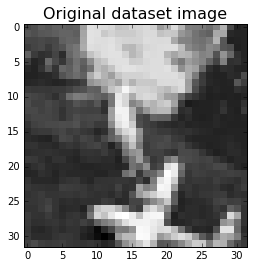

Scaling data to range (-1, 1)


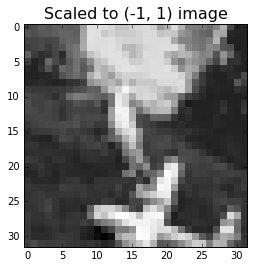

Normalizing data (mean 0, std 1)


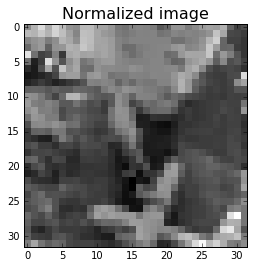

In [119]:
%matplotlib inline
img =  Xtr[25][0:1024].reshape((32,32))
plt.imshow(img, cmap='gray', interpolation='nearest')
plt.title("Original dataset image", fontsize=16)
plt.show()

img_scaled_2 = scale_data(img, normalize=False, myrange=(-1,1))
plt.title("Scaled to (-1, 1) image", fontsize=16)
plt.imshow(img_scaled_2, cmap='gray', interpolation='nearest')
plt.show()

img_scaled_01 = scale_data(img, normalize=True)
plt.imshow(img_scaled_01, cmap='gray', interpolation='nearest')
plt.title("Normalized image", fontsize=16)
plt.show()

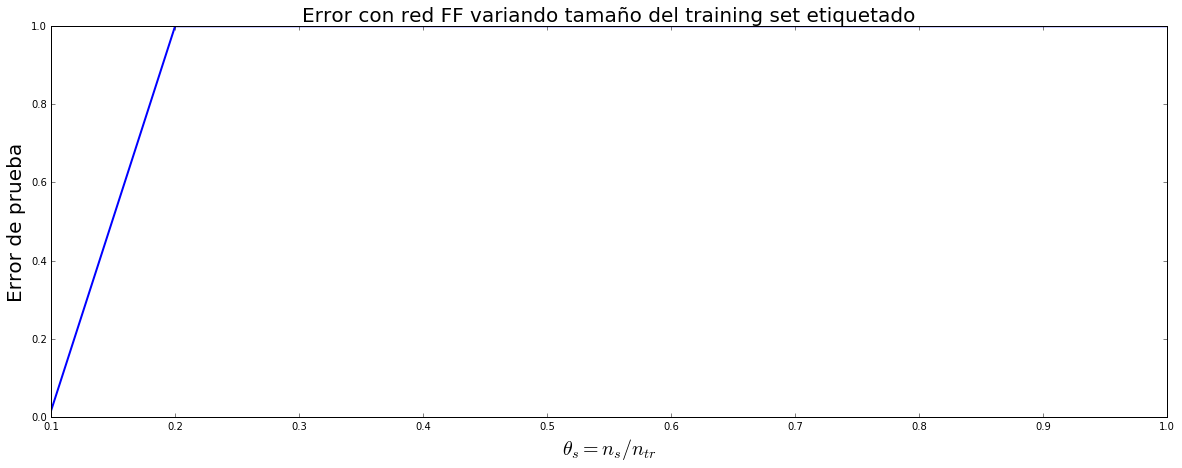

In [143]:
plt.figure(figsize=(20,7))
thetas = np.linspace(0.1, 1, 10)
errors = 1 - np.array([0.9844, 0, 0, 0, 0, 0, 0, 0, 0, 0])
plt.title(u'Error con red FF variando tamaño del training set etiquetado', fontsize=20)
plt.xlabel(r'$ \theta _s = n_s/n_{tr}$', fontsize=20)
plt.ylabel(u'Error de prueba', fontsize=20)
plt.xticks(thetas)
plt.xlim((0.1, 1))
plt.plot(thetas, errors, lw=2)
plt.show()